In [11]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [12]:
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.gaussian_measurement import GaussianMeasurement
from core.linalg_utils import random_unitary_matrix
import numpy as np

In [13]:
# === パラメータ設定 ===
n = 64
shape = (n,)
var = 1e-4
rng = np.random.default_rng(123)

U1 = random_unitary_matrix(n, rng=rng)
U2 = random_unitary_matrix(n, rng=rng)

In [14]:
# === グラフ定義 ===
class SplitGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = GaussianPrior(mean=0.0, var=1.0, shape=shape)
        self.Y1 = UnitaryPropagator(U1) @ self.X
        self.Z1 = GaussianMeasurement(var=var) @ self.Y1
        self.Y2 = UnitaryPropagator(U2) @ self.X
        self.Z2 = GaussianMeasurement( var=var) @ self.Y2
        self.compile()

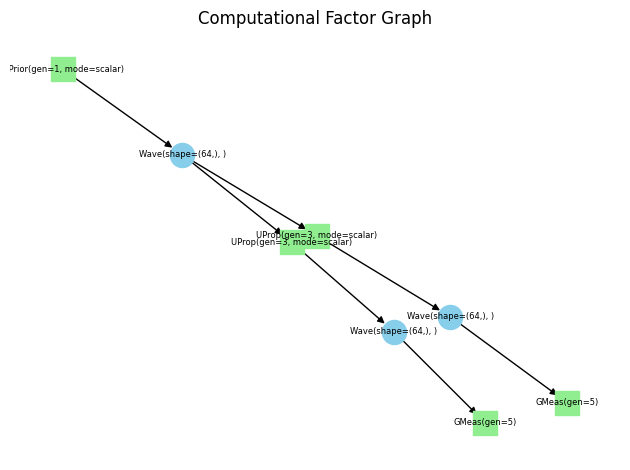

In [15]:
g = SplitGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [16]:
g.set_init_rng(np.random.default_rng(1))
g.generate_sample(rng=np.random.default_rng(9))

true_x = g.X.get_sample()
g.Z1.update_observed_from_sample()
g.Z2.update_observed_from_sample()

In [17]:
def monitor(graph, t):
    if t % 10 == 0:
        est = graph.X.compute_belief().data
        err = np.mean(np.abs(est - true_x)**2)
        print(f"[t={t}] MSE = {err:.3e}")

g.run(n_iter=50, callback=monitor)

[t=0] MSE = 8.898e-05
[t=10] MSE = 8.895e-05
[t=20] MSE = 8.895e-05
[t=30] MSE = 8.895e-05
[t=40] MSE = 8.895e-05


In [18]:
g.X.precision_mode

'scalar'

## Coded Diffraction Pattern

In [19]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import random_phase_mask
from graph.structure.graph import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

H, W = 128, 128
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(seed=42)

class CDPGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = GaussianPrior(mean=0.0, var=1.0, shape=shape)

        # Measurement を self に明示的に保持
        self.Z_list = []
        for i in range(4):
            phase = random_phase_mask(shape, rng=rng)
            Y = PhaseMaskPropagator(phase) @ self.X
            F = FFT2DPropagator(shape=shape) @ Y
            Z = AmplitudeMeasurement(var=var, damping=0.3) @ F
            setattr(self, f"Z{i+1}", Z)  # self.Z1, self.Z2, ... に登録
            self.Z_list.append(Z)

        self.compile()

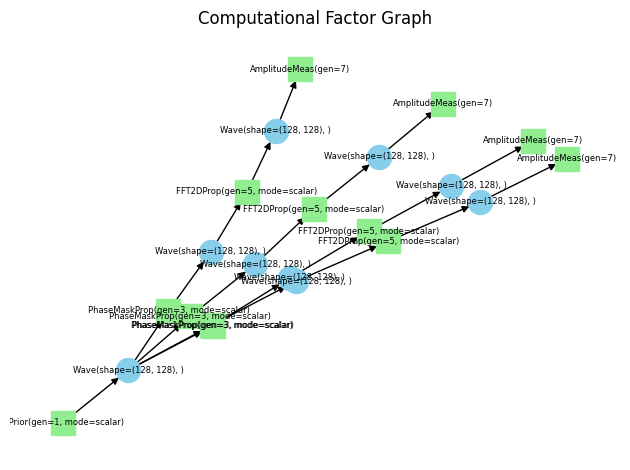

In [20]:
g = CDPGraph()
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)

In [21]:
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
true_x = g.X.get_sample()

In [22]:
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor)

[t=0] PMSE = 2.23548e+00
[t=20] PMSE = 2.32728e+00
[t=40] PMSE = 6.53271e-02
[t=60] PMSE = 2.56635e-04
[t=80] PMSE = 1.52360e-04
[t=100] PMSE = 1.52289e-04
[t=120] PMSE = 1.52288e-04
[t=140] PMSE = 1.52288e-04
[t=160] PMSE = 1.52288e-04
[t=180] PMSE = 1.52288e-04


In [23]:
%prun -l 40 -s cumulative g.run(n_iter=200, callback=monitor)

[t=0] PMSE = 1.52288e-04
[t=20] PMSE = 1.52288e-04
[t=40] PMSE = 1.52288e-04
[t=60] PMSE = 1.52288e-04
[t=80] PMSE = 1.52288e-04
[t=100] PMSE = 1.52288e-04
[t=120] PMSE = 1.52288e-04
[t=140] PMSE = 1.52288e-04
[t=160] PMSE = 1.52288e-04
[t=180] PMSE = 1.52288e-04
 

         288275 function calls in 1.205 seconds

   Ordered by: cumulative time
   List reduced from 132 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.205    1.205 {built-in method builtins.exec}
        1    0.000    0.000    1.205    1.205 <string>:1(<module>)
        1    0.000    0.000    1.205    1.205 graph.py:108(run)
      200    0.002    0.000    0.850    0.004 graph.py:103(backward)
      800    0.002    0.000    0.435    0.001 fft_2d_propagator.py:104(backward)
      800    0.044    0.000    0.370    0.000 fft_2d_propagator.py:55(compute_belief)
      800    0.001    0.000    0.255    0.000 base.py:96(backward)
     1600    0.005    0.000    0.246    0.000 _pocketfft.py:701(_raw_fftnd)
      200    0.002    0.000    0.245    0.001 graph.py:98(forward)
      800    0.003    0.000    0.244    0.000 amplitude_measurement.py:84(_compute_message)
     3200    0.219    0.000    0.227    0.000